<div style="background-color: #f0f8ff; padding: 10px;">
    <font color="black" face="verdana" size="3"><b>Team Members </b></font>
    
   <font color="black" face="verdana" size="3">
       <br/>
Mansi Sharma (ms89743)
<br/>
Meghavi Singhaniya (ms89872)
<br/>
Milind Bhatia (mb67324)
<br/>
Meenakshi Sundaram (ms88544)
<br/>
Udit Dhand (Umd84)
    
  </font>
</div>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

import spacy

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
#WebDriver is a browser automation framework that works with open source APIs.
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')

chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

### Task A: Extracting Beer Reviews

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">

We scraped a total of 7.7K reviews and kept the reviews for the products which had atleast 5 reviews which resulted in 6.3 k reviews which we are using for subsequent analysis
       
  </font>
</div>

In [ ]:
driver = webdriver.Chrome(options=chrome_options)

In [ ]:
url_list = ['https://www.beeradvocate.com/beer/popular/','https://www.beeradvocate.com/beer/worst/',\
            'https://www.beeradvocate.com/beer/top-rated/','https://www.beeradvocate.com/beer/fame/',\
            'https://www.beeradvocate.com/beer/top-styles/','https://www.beeradvocate.com/beer/trending/']

In [ ]:
relevant_links = []
for a in url_list:
    driver.get(a)
    links_list = []
    links = driver.find_elements(By.TAG_NAME,'a')
    for lnk in links:
       links_list.append(lnk.get_attribute('href'))

    for i in links_list:
        if "/profile/" in str(i):
            relevant_links.append(i)
relevant_links = list(set(relevant_links))

driver.quit()

In [ ]:
# Cleaning the comment data 
def split_comment(s):
    split_r=s.split('\n')
    comment_body = split_r[4:-1]
    return comment_body

def clean_comment(t):
    string = str(t)
    string=string.rstrip(']').lstrip('[')
    string= string.replace('\n', ' ').replace(",", "")
    string=string.replace("'", "").replace('"', "")
    string=string.lower()
    return string

In [ ]:
df = pd.DataFrame(columns = ["product_name", "user_rating","raw_comments", "product_review"])

# Cleaning the scraped data and convert into the desired dataframe
string = 'Rated: '
df['product_name'] = product
df['raw_comments'] = reviews
df['user_rating'] = df['raw_comments'].map(lambda x: x.split('\n')[2].split('/')[0] if(string not in x) else np.nan)
df['product_review']=df['raw_comments'].apply(lambda x: clean_comment(split_comment(x)) if(string not in x) else np.nan)

df.dropna(inplace = True)
df.drop(columns = ['raw_comments'], inplace = True)
df.reset_index(drop = True, inplace = True)
df.to_csv('Comments.csv')

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords

In [2]:
df_reviews = pd.read_csv("Comments.csv")
df_reviews

,Unnamed: 0,product_name,user_rating,product_review
0,0,Carlton Cold,2.01,looks like beer smells and tastes like urine w...
1,1,Carlton Cold,2.23,september 2008: 375 ml clear bottle courtesy o...
2,2,Carlton Cold,1.02,i recently reviewed victoria bitter which i dr...
3,3,Carlton Cold,2.95,carlton cold is filtered below zero degrees ce...
4,4,Carlton Cold,1.62,format: a standard clear 355ml bottle with tha...
...,...,...,...,...
7207,7207,Sculpin,4.08,smells great with an exquisite finish. with a ...
7208,7208,Bar Fly,4.57,yesterdays meandering around through the bottl...
7209,7209,Bar Fly,4.29,the smoky aroma is stronger than it follows on...
7210,7210,Bar Fly,4.16,midnight black body topped with a dense creamy...


In [4]:
count_df_rev = df_reviews.groupby('product_name').nunique().reset_index()
print("Beers with 5 or more reviews : ", count_df_rev[count_df_rev['user_rating'] >=5]['user_rating'].sum())

beer_5m = list(count_df_rev[count_df_rev['user_rating'] >=5]['product_name'].unique())

df_reviews = df_reviews[df_reviews['product_name'].isin(beer_5m)]

Beers with 5 or more reviews :  6283


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">

To ensure that we're accurately recommending beers to the customer, we're only including products in our data which have atleast 5 reviews.
    
  </font>
</div>

### Task B : Finding Attributes

In [5]:
# Download NLTK stopwords (you only need to do this once)
nltk.download('stopwords')

# Extract the comment column
comments = df_reviews[df_reviews['product_review'].apply(lambda x: isinstance(x, str))]['product_review']

# Get the NLTK English stop words
stop_words = set(stopwords.words('english'))

# Tokenize and preprocess the comments (remove punctuation, convert to lowercase, and remove stop words)
def preprocesstext(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = re.findall(r'\b\w+\b', text.lower())  # Tokenize and convert to lowercase
    nswords = [word for word in words if word not in stop_words]
    return list(set(nswords))

# Tokenize and preprocess the comments, removing stop words
words_nostop = []
for comment in comments:
    words = preprocesstext(comment)
    words_nostop.extend(words)

# Calculate word frequencies
words_nostop_freq = pd.Series(words_nostop).value_counts()

wnf_df = pd.DataFrame(words_nostop_freq)
wnf_df = wnf_df.reset_index()
wnf_df = wnf_df.rename(columns={'index': 'words', 0: 'frequency'})

wnf_df.to_csv('review_words.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/milindbhatia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import pandas as pd
file=pd.read_csv("beer attributes.csv")

In [7]:
file.head()

,attribute,frequency
0,light,2029
1,carbonation,1835
2,sweet,1669
3,malt,1654
4,white,1469


In [8]:
attributes=file[file["frequency"]>=700]["attribute"]

In [9]:
print("Available Attributes:")

for idx, attr in enumerate(attributes):
    print(f"{idx+1}.{attr}")

Available Attributes:
1.light
2.carbonation
3.sweet
4.malt
5.white
6.medium
7.dark
8.smooth
9.bitterness
10.clear
11.brown
12.chocolate
13.dry
14.sweetness
15.bitter
16.caramel
17.golden
18.black
19.fruit


In [10]:
selected_attributes = ['light', 'carbonation', 'sweet']
selected_attributes

['light', 'carbonation', 'sweet']

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">

After performing a word frequency analysis, we looked at words that are actually beer attributes and loaded them in a separate csv file for ease of reference. After compiling these attributes, we only looked at attributes with more than 700 frequency. From these attributes, we chose 3 - these attributes were choses based on the team's beer preferences. Ironically, our team likes sweet beer which implies that we should instead consider drinking juices.
    
  </font>
</div>

### Task C: Perform a similarity analysis using cosine similarity (without word embeddings) with the 3 attributes specified by the customer and the reviews. 

In [11]:
#cosine similarity analysis
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

clean_df = df_reviews[df_reviews['product_review'].apply(lambda x: isinstance(x, str))].copy(deep=True)

attr_str=" ".join(selected_attributes)

In [12]:
def bow_similarity(reviews, attributes):
    documents=reviews+[attributes]
    vectorizer=CountVectorizer(stop_words='english')
    sparse_matrix=vectorizer.fit_transform(documents)
    dtm_matrix=sparse_matrix.todense()
    df=pd.DataFrame(dtm_matrix,columns=vectorizer.get_feature_names_out(),index=list(range(len(documents))))
    return cosine_similarity(df,df)[:-1,-1]

bow_similarity_scores=bow_similarity(list(clean_df["product_review"]),attr_str)

In [13]:
results_df=clean_df.copy()
results_df.drop(["Unnamed: 0","user_rating"],axis=1,inplace=True)
results_df["similarity_score"]=bow_similarity_scores
results_df.head()

,product_name,product_review,similarity_score
0,Carlton Cold,looks like beer smells and tastes like urine w...,0.000000
1,Carlton Cold,september 2008: 375 ml clear bottle courtesy o...,0.080064
2,Carlton Cold,i recently reviewed victoria bitter which i dr...,0.040723
3,Carlton Cold,carlton cold is filtered below zero degrees ce...,0.000000
4,Carlton Cold,format: a standard clear 355ml bottle with tha...,0.204124


### Task D:  For every review, perform a sentiment analysis 

In [14]:
#Sentiment Analysis
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
#initialize the sentiment analyzer
analyser = SentimentIntensityAnalyzer()
#Convert the top-10 attributes to score 0
for word in attributes[:10] : 
  analyser.lexicon[word] = 0

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/milindbhatia/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
#function for calculating sentiment score
def sentiment_scores(review):
    score = analyser.polarity_scores(review)['compound']
    return score

In [16]:
#performed on original data reviews
df_senti = df_reviews[df_reviews['product_review'].apply(lambda x: isinstance(x, str))].copy(deep=True)
df_senti["sentiment_score"] = df_senti["product_review"].apply(sentiment_scores)
df_senti.head()

,Unnamed: 0,product_name,user_rating,product_review,sentiment_score
0,0,Carlton Cold,2.01,looks like beer smells and tastes like urine w...,0.5010
1,1,Carlton Cold,2.23,september 2008: 375 ml clear bottle courtesy o...,0.3612
2,2,Carlton Cold,1.02,i recently reviewed victoria bitter which i dr...,-0.9959
3,3,Carlton Cold,2.95,carlton cold is filtered below zero degrees ce...,0.8625
4,4,Carlton Cold,1.62,format: a standard clear 355ml bottle with tha...,0.8197


In [17]:
results_df["sentiment_score"] = df_senti["sentiment_score"]
results_df.describe()

,similarity_score,sentiment_score
count,6561.000000,6561.000000
mean,0.076733,0.578447
std,0.094339,0.481917
min,0.000000,-0.995900
25%,0.000000,0.380200
50%,0.051640,0.792100
75%,0.129099,0.932800
max,0.577350,0.999300


In [18]:
results_df

,product_name,product_review,similarity_score,sentiment_score
0,Carlton Cold,looks like beer smells and tastes like urine w...,0.000000,0.5010
1,Carlton Cold,september 2008: 375 ml clear bottle courtesy o...,0.080064,0.3612
2,Carlton Cold,i recently reviewed victoria bitter which i dr...,0.040723,-0.9959
3,Carlton Cold,carlton cold is filtered below zero degrees ce...,0.000000,0.8625
4,Carlton Cold,format: a standard clear 355ml bottle with tha...,0.204124,0.8197
...,...,...,...,...
7203,Sculpin,12oz can pkg 031323 (2 months ago) poured into...,0.276026,0.4497
7204,Sculpin,great san diego ipa. lovely goldenrod color bi...,0.000000,0.9698
7205,Sculpin,not a big fan. too floral malty. carbonated,0.000000,-0.2411
7206,Sculpin,classic west coast ipa honestly prefer this on...,0.000000,0.6705


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">
We use VADER to perform sentiment analysis and to ensure that the attributes themselves do not affect the sentiment score we manually set the top 10 attributes score to 0 by altering the lexicon.
  </font>
</div>

### Task E:

In [19]:
results_df["eval_score"] = results_df["similarity_score"]*results_df["sentiment_score"]
results_df.head()

,product_name,product_review,similarity_score,sentiment_score,eval_score
0,Carlton Cold,looks like beer smells and tastes like urine w...,0.000000,0.5010,0.000000
1,Carlton Cold,september 2008: 375 ml clear bottle courtesy o...,0.080064,0.3612,0.028919
2,Carlton Cold,i recently reviewed victoria bitter which i dr...,0.040723,-0.9959,-0.040556
3,Carlton Cold,carlton cold is filtered below zero degrees ce...,0.000000,0.8625,0.000000
4,Carlton Cold,format: a standard clear 355ml bottle with tha...,0.204124,0.8197,0.167321


In [20]:
results_df=results_df.groupby("product_name").mean().sort_values(by='eval_score',ascending=False).reset_index() #top3 recommendations in terms of cosine similarity

/var/folders/2q/jjvry_s10q578x_6qd2kc8j00000gn/T/ipykernel_25323/1319320589.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df=results_df.groupby("product_name").mean().sort_values(by='eval_score',ascending=False).reset_index() #top3 recommendations in terms of cosine similarity


In [21]:
results_df

,product_name,similarity_score,sentiment_score,eval_score
0,Old Milwaukee Light,0.185286,0.804057,0.178926
1,Brewer's Reserve Bourbon Barrel Stout,0.194900,0.876245,0.176144
2,Weihenstephaner Festbier,0.232522,0.634533,0.171711
3,Eureka - Citra,0.166977,0.960512,0.161771
4,Amstel Light,0.227613,0.561714,0.159640
...,...,...,...,...
769,Bud Light,0.097070,-0.180086,-0.027533
770,Becks's Vier,0.145976,0.041020,-0.035144
771,Pearl River Lager Beer,0.113997,-0.041975,-0.040677
772,Burleigh Bighead,0.083472,-0.395786,-0.046737


In [22]:
results_df.head(3)

,product_name,similarity_score,sentiment_score,eval_score
0,Old Milwaukee Light,0.185286,0.804057,0.178926
1,Brewer's Reserve Bourbon Barrel Stout,0.194900,0.876245,0.176144
2,Weihenstephaner Festbier,0.232522,0.634533,0.171711


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">

Based on the similarity and sentiment score, we calculated the evaluation score from which we calculated the top 3 recommended beers for the customer. 

The top three recommended beers for the customer are:

1.**Old Milwaukee Light**

2.**Brewer's Reserve Bourbon Barrel Stout**

3.**Weinhenstenphaner Festbier**   
  </font>
</div>

### Task F:

In [23]:
# Download NLTK stopwords (you only need to do this once)
nltk.download('stopwords')
# Get the NLTK English stop words
stop_words = set(stopwords.words('english'))

wv_df = df_reviews.copy()

# Tokenize and preprocess the comments (remove punctuation, convert to lowercase, and remove stop words)
def preprocesstext(text):
    if isinstance(text, str):  # Check if 'text' is a string
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        words = re.findall(r'\b\w+\b', text.lower())  # Tokenize and convert to lowercase
        nswords = [word for word in words if word not in stop_words]
        return ' '.join(nswords)
    else:
        return ''

wv_df['review_processed'] = wv_df['product_review'].apply(preprocesstext)
wv_df = wv_df[wv_df['review_processed'] != '']
wv_df

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/milindbhatia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,product_name,user_rating,product_review,review_processed
0,0,Carlton Cold,2.01,looks like beer smells and tastes like urine w...,looks like beer smells tastes like urine metal...
1,1,Carlton Cold,2.23,september 2008: 375 ml clear bottle courtesy o...,september 2008 375 ml clear bottle courtesy ca...
2,2,Carlton Cold,1.02,i recently reviewed victoria bitter which i dr...,recently reviewed victoria bitter drank old ti...
3,3,Carlton Cold,2.95,carlton cold is filtered below zero degrees ce...,carlton cold filtered zero degrees celsius cre...
4,4,Carlton Cold,1.62,format: a standard clear 355ml bottle with tha...,format standard clear 355ml bottle old carlton...
...,...,...,...,...,...
7203,7203,Sculpin,3.78,12oz can pkg 031323 (2 months ago) poured into...,12oz pkg 031323 2 months ago poured spiegelau ...
7204,7204,Sculpin,4.15,great san diego ipa. lovely goldenrod color bi...,great san diego ipa lovely goldenrod color big...
7205,7205,Sculpin,3.90,not a big fan. too floral malty. carbonated,big fan floral malty carbonated
7206,7206,Sculpin,4.43,classic west coast ipa honestly prefer this on...,classic west coast ipa honestly prefer one ico...


In [24]:
import spacy
nlp = spacy.load("en_core_web_md")

In [25]:
def calculate_similarity(attribute, review):
    attribute_doc = nlp(attribute)
    review_doc = nlp(review)
    return attribute_doc.similarity(review_doc)

In [26]:
att_str = " ".join(selected_attributes)
att_str

'light carbonation sweet'

In [27]:
product_scores_ind = {}

for product_name, group in wv_df.groupby("product_name"):
    product_scores_ind[product_name] = {}
    scores_i = [calculate_similarity(att_str, review) for review in group["product_review"]]
    avg_score_i = sum(scores_i) / len(scores_i)
    product_scores_ind[product_name] = avg_score_i

df_wv_ind = pd.DataFrame(list(product_scores_ind.items()), columns=['product_name', 'sim_score_wb'])
df_wv_ind.sort_values(by='sim_score_wb',ascending=False)

/var/folders/2q/jjvry_s10q578x_6qd2kc8j00000gn/T/ipykernel_25323/604577027.py:4: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return attribute_doc.similarity(review_doc)


,product_name,sim_score_wb
116,Bourbon County Brand Coffee Stout,0.734125
210,DDDoublegangerrr,0.730299
55,Ayinger Weizenbock,0.728652
22,Achel Trappist Extra,0.727915
126,Brewer's Reserve Bourbon Barrel Stout,0.726875
...,...,...
187,Clasica,0.490140
693,The Greenest Green,0.479123
590,Redd's Apple Ale,0.466500
434,Marshmallow Handjee,0.403186


In [28]:
df_wv_ind.sort_values(by='sim_score_wb',ascending=False).head(3)

,product_name,sim_score_wb
116,Bourbon County Brand Coffee Stout,0.734125
210,DDDoublegangerrr,0.730299
55,Ayinger Weizenbock,0.728652


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">

If we use word vectors instead of our traditional bag-of-words, our recommendations would change as follows:

The top three recommended beers for the customer are:
1. **Bourbon County Brand Coffee Stout**
2. **DDDoublegangerrr**
3. **Ayinger Weizenbock**

Our recommendations from two approaches are different, let's plot this data to look at similarity scores for all 6 products.
    
  </font>
</div>

In [29]:
recom_beers = ["Bourbon County Brand Coffee Stout", "DDDoublegangerrr", "Ayinger Weizenbock", "Old Milwaukee Light", "Brewer's Reserve Bourbon Barrel Stout", "Weihenstephaner Festbier"]

bow_data = results_df[results_df['product_name'].isin(recom_beers)][['product_name','similarity_score']]
we_data = df_wv_ind[df_wv_ind['product_name'].isin(recom_beers)]

joined_data = pd.merge(bow_data,we_data,on='product_name').sort_values(by='sim_score_wb')
joined_data


,product_name,similarity_score,sim_score_wb
2,Weihenstephaner Festbier,0.232522,0.682576
0,Old Milwaukee Light,0.185286,0.686324
1,Brewer's Reserve Bourbon Barrel Stout,0.194900,0.726875
3,Ayinger Weizenbock,0.102719,0.728652
4,DDDoublegangerrr,0.072302,0.730299
5,Bourbon County Brand Coffee Stout,0.031197,0.734125


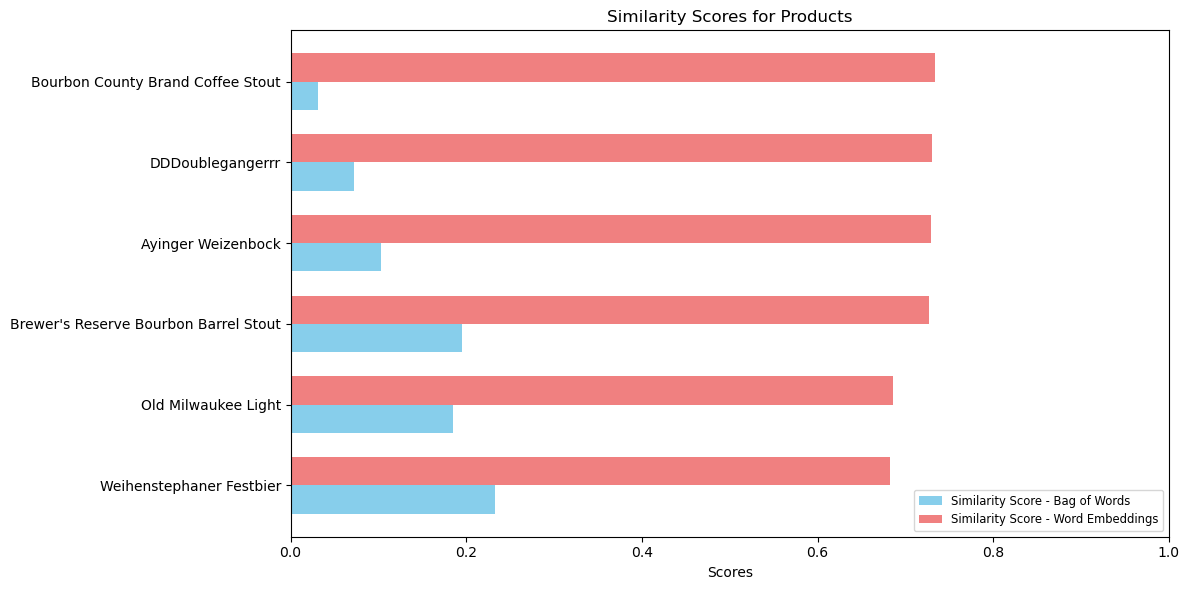

In [30]:
indices = np.arange(joined_data['product_name'].shape[0])

# Set the width of the bars
bar_width = 0.35

# Create a bar graph with grouped bars
plt.figure(figsize=(12, 6))
plt.barh(indices - bar_width/2, joined_data['similarity_score'], bar_width, label='Similarity Score - Bag of Words', color='skyblue', align='center')
plt.barh(indices + bar_width/2, joined_data['sim_score_wb'], bar_width, label='Similarity Score - Word Embeddings', color='lightcoral', align='center')

# Set labels and titles
plt.yticks(indices, joined_data['product_name'])
plt.xlabel('Scores')
plt.title('Similarity Scores for Products')
plt.legend(loc='lower right', fontsize='small')
plt.xlim(0, 1)
# Show the plot
plt.tight_layout()
plt.show()

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">

**Analysis of Similarity Scores**

In the provided graph, we observe a comparison between similarity scores obtained from two different approaches: Bag of Words (BoW) and Word Embeddings (Word2Vec).

**Bag of Words Approach:**

- The Bag of Words approach represents products based on the exact match of individual attribute mentions in the reviews
- For the products recommended by this approach, we notice that their similarity scores are far behind the similarity scores of word2vec

**Word Embeddings (Word2Vec) Approach:**

- Word Embeddings, on the other hand, captures semantic relationships and context within the descriptions.
- Interestingly, for the products recommended by Word Embeddings, we see notably higher similarity scores when compared to the scores assigned by Bag of Words.
- This disparity implies that Word Embeddings excel in identifying subtle nuances and semantic similarities that the Bag of Words approach might miss.

**Conclusion:**
The recommendations provided by bag of words are not be eliminated because for those recommendations, word to vec also provides a comparatively high similarity score. Especially, in the context of beers, where people are less likely to use alternate words while taking about the specific attributes, we believe that the recommendations provided by bag of words are more relevant than those provided by word2vec. Hence, we would choose to go ahead with the recommendations provided by Bag of Words.  


  </font>
</div>

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">

To further deep dive, let's calculate similarity scores for both of the following approaches for each attribute:
1. Bag of Words

  </font>
</div>

In [31]:
def attr_bow_similarity(reviews, attributes):
    documents=reviews+attributes
    vectorizer=CountVectorizer(stop_words='english')
    sparse_dtm=vectorizer.fit_transform(documents)
    attr_dtm=sparse_dtm.todense()
    attr_sim_df=pd.DataFrame(attr_dtm,columns=vectorizer.get_feature_names_out(),index=list(range(len(documents))))
    return cosine_similarity(attr_sim_df,attr_sim_df)[:-3,-3:]

sim_table=attr_bow_similarity(list(clean_df["product_review"]),selected_attributes)
results_df2=clean_df.copy(deep=True)
results_df2.drop(["Unnamed: 0","user_rating"],inplace=True,axis=1)
results_df2.loc[:,selected_attributes]=sim_table

results_df2.drop("product_review",inplace=True,axis=1)
bow_df=results_df2.groupby("product_name").agg(np.mean)

bow_df["avg_cosine_sim_score"]=bow_df.iloc[:,0:3].mean(axis=1)
bow_df = bow_df.reset_index()
bow_df.sort_values(by = 'avg_cosine_sim_score', ascending=False)

,product_name,light,carbonation,sweet,avg_cosine_sim_score
316,Hahn Premium Light,0.336953,0.067736,0.044456,0.149715
679,Tecate Light,0.279866,0.035932,0.109558,0.141785
747,Weihenstephaner Festbier,0.246155,0.077197,0.079388,0.134247
33,Amstel Light,0.362898,0.020893,0.010447,0.131413
293,Genny Light,0.304969,0.079933,0.000000,0.128300
...,...,...,...,...,...
503,Oculto,0.000000,0.000000,0.000000,0.000000
480,Natty Daddy (6%),0.000000,0.000000,0.000000,0.000000
162,Carlton Draught,0.000000,0.000000,0.000000,0.000000
76,Berserker Imperial Stout,0.000000,0.000000,0.000000,0.000000


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">

2. Word Embeddings

  </font>
</div>

In [32]:
product_scores = {}
for product_name, group in wv_df.groupby("product_name"):
    product_scores[product_name] = {}
    for attribute in selected_attributes:
        scores = [calculate_similarity(attribute, review) for review in group["product_review"]]
        avg_score = sum(scores) / len(scores)
        product_scores[product_name][attribute] = avg_score

/var/folders/2q/jjvry_s10q578x_6qd2kc8j00000gn/T/ipykernel_25323/604577027.py:4: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return attribute_doc.similarity(review_doc)


In [33]:
for product, attributes in product_scores.items():
    avg_score = sum(attributes.values()) / len(attributes)
    product_scores[product]['avg'] = avg_score

In [34]:
df_word_vec = pd.DataFrame.from_dict(product_scores, orient='index')
df_word_vec.sort_values(by='avg',ascending=False)

,light,carbonation,sweet,avg
Bourbon County Brand Coffee Stout,0.630812,0.547695,0.337091,0.505199
Triple Citra Daydream,0.621780,0.474597,0.415939,0.504105
Ayinger Weizenbock,0.620809,0.518772,0.371140,0.503574
DDDoublegangerrr,0.630065,0.532746,0.345879,0.502897
Landbier,0.625136,0.511666,0.368391,0.501731
...,...,...,...,...
Clasica,0.441164,0.378099,0.182182,0.333815
The Greenest Green,0.416477,0.362629,0.207170,0.328759
Redd's Apple Ale,0.392177,0.293895,0.289810,0.325294
Fort Point Pale Ale - Galaxy Dry Hopped,0.342997,0.270846,0.224443,0.279429


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">

Comparing the two tables above, we can confer our conclusion from earlier analysis that word embeddings, in our case, excels more than bag of words when looking at similarity scores between attributes and product reviews. However, since bag of words perform direct comparison, we would trust it more than word embeddings in this case.

  </font>
</div>

In [35]:
df_word_vec=df_word_vec.reset_index().rename(columns={'index': 'product_name'})
bow_df = bow_df.reset_index()

In [36]:
results_df=pd.merge(results_df,df_wv_ind[['product_name','sim_score_wb']],on="product_name", how="inner")

In [37]:
results_df=results_df.rename(columns={'similarity_score': 'similarity_score_cosine','sim_score_wb': 'similarity_score_wordvec'})

In [38]:
results_df

,product_name,similarity_score_cosine,sentiment_score,eval_score,similarity_score_wordvec
0,Old Milwaukee Light,0.185286,0.804057,0.178926,0.686324
1,Brewer's Reserve Bourbon Barrel Stout,0.194900,0.876245,0.176144,0.726875
2,Weihenstephaner Festbier,0.232522,0.634533,0.171711,0.682576
3,Eureka - Citra,0.166977,0.960512,0.161771,0.703355
4,Amstel Light,0.227613,0.561714,0.159640,0.613444
...,...,...,...,...,...
769,Bud Light,0.097070,-0.180086,-0.027533,0.528584
770,Becks's Vier,0.145976,0.041020,-0.035144,0.678427
771,Pearl River Lager Beer,0.113997,-0.041975,-0.040677,0.610794
772,Burleigh Bighead,0.083472,-0.395786,-0.046737,0.650943


### Task G:

In [39]:
df_g = df_reviews.groupby('product_name')['user_rating'].mean().reset_index().sort_values(by='user_rating',ascending=False).head(3)
df_g

,product_name,user_rating
554,Pliny The Younger,4.863750
748,Weihenstephaner Hefeweissbier,4.855455
101,Blessed,4.808889


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">

If we use simply ratings for each product below would the recommendations:

The top three recommended beers for the customer are:
1. **Pliny The Younger**
2. **Weihenstephaner Hefeweissbier**
3. **Blessed**

To check if these makes sense or if it would suffice the purpose, let's see similarity and sentiment scores of these products.
    
  </font>
</div>

In [40]:
temp_ls = list(df_g['product_name'].unique())
results_df[results_df['product_name'].isin(temp_ls)]

,product_name,similarity_score_cosine,sentiment_score,eval_score,similarity_score_wordvec
510,Blessed,0.068037,0.565344,0.031873,0.569281
539,Pliny The Younger,0.032356,0.712213,0.029121,0.528419
646,Weihenstephaner Hefeweissbier,0.020202,0.564600,0.017846,0.620340


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">

Based on the similarity and sentiment scores, we should not recommend these products to the customers. The similarity scores from bag of words are extremely low and the similarity scores are not too high compared to the scores of other products. 

This implies that these product do not align with the attributes given by the customer.

In conclusion, recommendations based on product ratings are likely to be misleading if we consider customer's preferences.
    
  </font>
</div>

### Task H: Association (Lift analysis)

<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">
Top 4 attributes from Task B are: light, carbonation, sweet and malt

After identifying this we attempt to find the lift of each of these attributes with the top 10 beers with highest reviews.
       To calculate lift:</br></br>
$$
\text{Lift}(\text{Attribute}, \text{Beer}) = \frac{\text{(No. of co-mentions of beer and attribute in a review)} \times \text{(Total no.of Reviews)}}{\text{(No. of unique reviews with the particular beer)} \times \text{(No. of unique reviews that have the particular attribute)}}
$$
  </font>
</div>

In [41]:
def preprocesstext(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = re.findall(r'\b\w+\b', text.lower())  # Tokenize and convert to lowercase
    nswords = [word for word in words if word not in stop_words]
    return list(set(nswords))

In [42]:
df1=df_reviews.copy()

In [43]:
# removing strop words
df1["cleaned_review_wo_stopwords"] = df1["product_review"].astype(str).apply(lambda review: preprocesstext(review))

In [44]:
# Top 4 attributes
top_4_attributes=["light","carbonation","sweet","malt"]
top_4_attributes

['light', 'carbonation', 'sweet', 'malt']

In [45]:
# Top 10 beers with highest comments
top_10_beer = df_reviews.groupby('product_name')['product_name'].count().sort_values(ascending=False)[:10]
top_10_beer = top_10_beer.index.to_list()
top_10_beer

['Oktoberfest',
 'IPA',
 'Porter',
 'Tripel',
 'Pale Ale',
 'Péché Mortel',
 'Boatswain Double IPA (Twin Screw Steamer)',
 'Camo Black Extra',
 'Cisk XS Extra Lager',
 'Four O Street Legal Malt Liquor']

In [46]:
lift_db = df1.copy()
lift_db = lift_db[['product_name','product_review','cleaned_review_wo_stopwords']].apply(pd.Series.explode).set_index(['product_name','product_review']).reset_index().drop_duplicates().copy()      

In [47]:
def lift(n, a, b, ab):
    l = ((n*ab)/(a*b))
    return (l)

In [ ]:
lift_values = pd.DataFrame(columns=['word_1','word_2','lift_val'])

for beer in top_10_beer:
    for attr in top_4_attributes:
        #Initialise lift to 0
        lift_db['beer'] = 0
        lift_db['attr'] = 0
        
        lift_db['beer'][lift_db['product_name'] == beer] = 1
        lift_db['attr'][lift_db['cleaned_review_wo_stopwords'] == attr] = 1
        
        c = lift_db.groupby(['product_name','product_review'])[['beer','attr']].sum().reset_index()   
        
        a = lift_db[lift_db['product_name']==beer]['product_review'].drop_duplicates().count()
        b = lift_db['attr'].sum()
        ab = c[(c['beer']>0) & (c['attr']==1)]['attr'].count()
        n = df1['product_review'].count()
        
        lift_val = lift(n, a, b, ab)
        
        lift_dict = {}
        lift_dict['word_1'] = beer
        lift_dict['word_2'] = attr
        lift_dict['lift_val'] = lift_val
        
        lift_values = lift_values.append(lift_dict, ignore_index=True)

In [49]:
similarity = pd.crosstab(lift_values['word_1'], lift_values['word_2'], lift_values['lift_val'], aggfunc=np.mean,rownames=['Beer'], colnames=['Attribute'])
similarity

Attribute,carbonation,light,malt,sweet
Beer,,,,
Boatswain Double IPA (Twin Screw Steamer),0.242497,0.434388,1.305100,0.795723
Camo Black Extra,0.484994,0.651582,1.044080,1.060964
Cisk XS Extra Lager,1.697479,1.303165,1.827140,2.652409
Four O Street Legal Malt Liquor,0.969988,1.085971,2.871221,2.652409
IPA,1.131653,0.868776,1.392107,0.618896
Oktoberfest,0.878480,0.983521,1.497172,1.761600
Pale Ale,0.912930,0.408836,1.473996,0.499277
Porter,1.204123,1.198312,1.152089,1.024379
Péché Mortel,1.369395,1.635344,1.473996,1.248193


<div style="background-color: #f0f8ff; padding: 10px;">
   <font color="black" face="verdana" size="3">
       
**Comparing Porter and Péché Mortel from the above table:**
       
We observe significant associations between the Porter beer and all four attributes, as indicated by lift values exceeding one. Péché Mortel also exhibits lift values greater than one, closely resembling those of Porter. Both of these beers are stouts with a notable malty profile and subtle chocolaty undertones that contribute to their sweetness. These lift values reaffirm this observation, highlighting the close similarity in the associations between these attributes and the two stout beers. Oh and they also align with our team's taste buds!
  </font>
</div>